# Concrete Slump Test Regression

The concrete slump test measures the consistency of fresh concrete before it sets. It is performed to check the workability of freshly made concrete, and therefore the ease with which concrete flows. It can also be used as an indicator of an improperly mixed batch.

<img src="https://i0.wp.com/civiconcepts.com/wp-content/uploads/2019/08/Slump-Cone-test-of-concrete.jpg?fit=977%2C488&ssl=1">

Our data set consists of various cement properties and the resulting slump test metrics in cm. Later on the set concrete is tested for its compressive strength 28 days later.

Input variables (7)(component kg in one M^3 concrete):
* Cement
* Slag
* Fly ash
* Water
* SP
* Coarse Aggr.
* Fine Aggr.

Output variables (3):
* SLUMP (cm)
* FLOW (cm)
* **28-day Compressive Strength (Mpa)**

Data Source: https://archive.ics.uci.edu/ml/datasets/Concrete+Slump+Test

*Credit: Yeh, I-Cheng, "Modeling slump flow of concrete using second-order regressions and artificial neural networks," Cement and Concrete Composites, Vol.29, No. 6, 474-480, 2007.*

# Importing dependencies

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimpy import clean_columns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from scipy.stats import skew

from sklearn.model_selection import cross_validate, cross_val_score

#%matplotlib inline
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Loading data

In [30]:
df0 = pd.read_csv("cement_slump.csv")
df = df0.copy()
df.head()

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,273.000,82.000,105.000,210.000,9.000,904.000,680.000,23.000,62.000,34.990
1,163.000,149.000,191.000,180.000,12.000,843.000,746.000,0.000,20.000,41.140
2,162.000,148.000,191.000,179.000,16.000,840.000,743.000,1.000,20.000,41.810
3,162.000,148.000,190.000,179.000,19.000,838.000,741.000,3.000,21.500,42.080
4,154.000,112.000,144.000,220.000,10.000,923.000,658.000,20.000,64.000,26.820


# EDA and Graphical analysis

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Cement                              103 non-null    float64
 1   Slag                                103 non-null    float64
 2   Fly ash                             103 non-null    float64
 3   Water                               103 non-null    float64
 4   SP                                  103 non-null    float64
 5   Coarse Aggr.                        103 non-null    float64
 6   Fine Aggr.                          103 non-null    float64
 7   SLUMP(cm)                           103 non-null    float64
 8   FLOW(cm)                            103 non-null    float64
 9   Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(10)
memory usage: 8.2 KB


In [32]:
df.columns

Index(['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.',
       'Fine Aggr.', 'SLUMP(cm)', 'FLOW(cm)',
       'Compressive Strength (28-day)(Mpa)'],
      dtype='object')

In [33]:
#Let us rectify the Incorrect Headers (Column names)
columns = ['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.',
       'Fine Aggr.', 'SLUMP(cm)', 'FLOW(cm)',
       'Compressive Strength (28-day)(Mpa)']

In [34]:
messy_df = pd.DataFrame(data = [], columns = columns, index = [0])
clean_df = clean_columns(messy_df)
clean_df.columns.tolist()

['cement',
 'slag',
 'fly_ash',
 'water',
 'sp',
 'coarse_aggr',
 'fine_aggr',
 'slump_cm',
 'flow_cm',
 'compressive_strength_28_day_mpa']

In [35]:
df.columns = clean_df.columns.tolist()
df.columns

Index(['cement', 'slag', 'fly_ash', 'water', 'sp', 'coarse_aggr', 'fine_aggr',
       'slump_cm', 'flow_cm', 'compressive_strength_28_day_mpa'],
      dtype='object')

In [36]:
# check missing values in data
df.isna().any()

cement                             False
slag                               False
fly_ash                            False
water                              False
sp                                 False
coarse_aggr                        False
fine_aggr                          False
slump_cm                           False
flow_cm                            False
compressive_strength_28_day_mpa    False
dtype: bool

In [37]:
# Descriptive statistics for each column
df.describe()

,cement,slag,fly_ash,water,sp,coarse_aggr,fine_aggr,slump_cm,flow_cm,compressive_strength_28_day_mpa
count,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000
mean,229.894,77.974,149.015,197.168,8.540,883.979,739.605,18.049,49.611,36.039
std,78.877,60.461,85.418,20.208,2.808,88.391,63.342,8.751,17.569,7.837
min,137.000,0.000,0.000,160.000,4.400,708.000,640.600,0.000,20.000,17.190
25%,152.000,0.050,115.500,180.000,6.000,819.500,684.500,14.500,38.500,30.900
50%,248.000,100.000,164.000,196.000,8.000,879.000,742.700,21.500,54.000,35.520
75%,303.900,125.000,235.950,209.500,10.000,952.800,788.000,24.000,63.750,41.205
max,374.000,193.000,260.000,240.000,19.000,1049.900,902.000,29.000,78.000,58.530


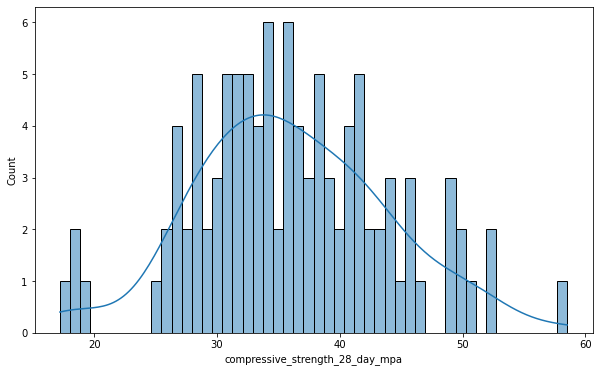

In [39]:
sns.histplot(df.compressive_strength_28_day_mpa, bins=50, kde=True);

In [40]:
skew(df.compressive_strength_28_day_mpa)

0.18907291231552745

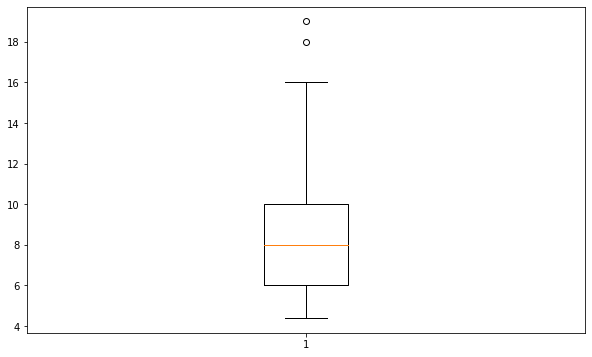

In [41]:
plt.boxplot(df.sp);

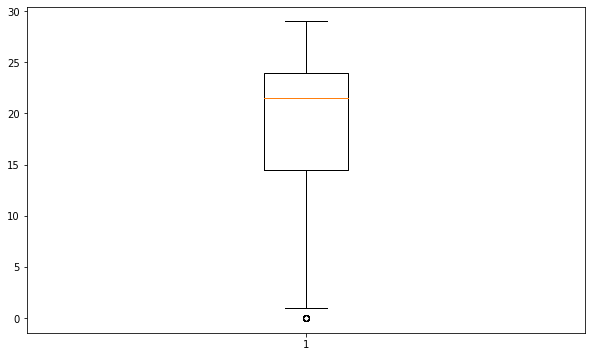

In [42]:
plt.boxplot(df['slump_cm']);

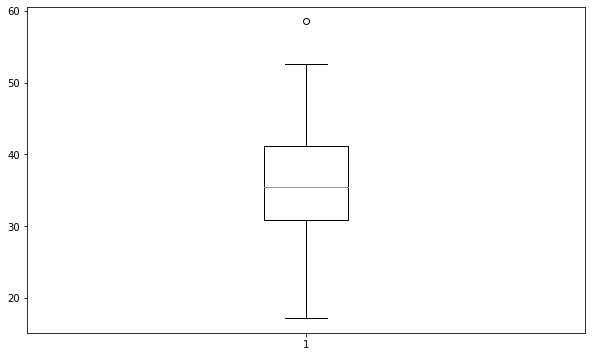

In [43]:
plt.boxplot(df['compressive_strength_28_day_mpa']);

**there aren't that many outliers in our data, so I'll continue with outliers.**

In [44]:
df.corr()

,cement,slag,fly_ash,water,sp,coarse_aggr,fine_aggr,slump_cm,flow_cm,compressive_strength_28_day_mpa
cement,1.000,-0.244,-0.487,0.221,-0.106,-0.310,0.057,0.146,0.186,0.446
slag,-0.244,1.000,-0.323,-0.027,0.307,-0.224,-0.184,-0.284,-0.327,-0.332
fly_ash,-0.487,-0.323,1.000,-0.241,-0.144,0.173,-0.283,-0.119,-0.055,0.444
water,0.221,-0.027,-0.241,1.000,-0.155,-0.602,0.115,0.467,0.632,-0.254
sp,-0.106,0.307,-0.144,-0.155,1.000,-0.104,0.058,-0.213,-0.176,-0.038
coarse_aggr,-0.310,-0.224,0.173,-0.602,-0.104,1.000,-0.489,-0.188,-0.326,-0.161
fine_aggr,0.057,-0.184,-0.283,0.115,0.058,-0.489,1.000,0.202,0.190,-0.155
slump_cm,0.146,-0.284,-0.119,0.467,-0.213,-0.188,0.202,1.000,0.906,-0.223
flow_cm,0.186,-0.327,-0.055,0.632,-0.176,-0.326,0.190,0.906,1.000,-0.124
compressive_strength_28_day_mpa,0.446,-0.332,0.444,-0.254,-0.038,-0.161,-0.155,-0.223,-0.124,1.000


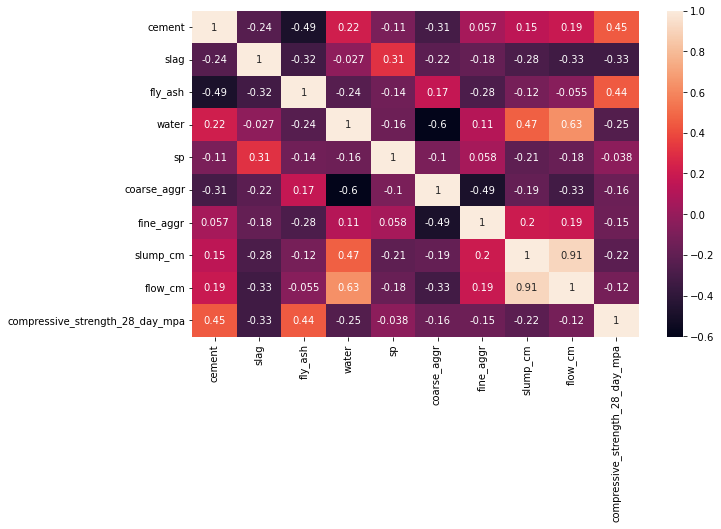

In [45]:
sns.heatmap(df.corr(), annot =True);

In [ ]:
# There are multicolineraty between slump_cm and flow_cm

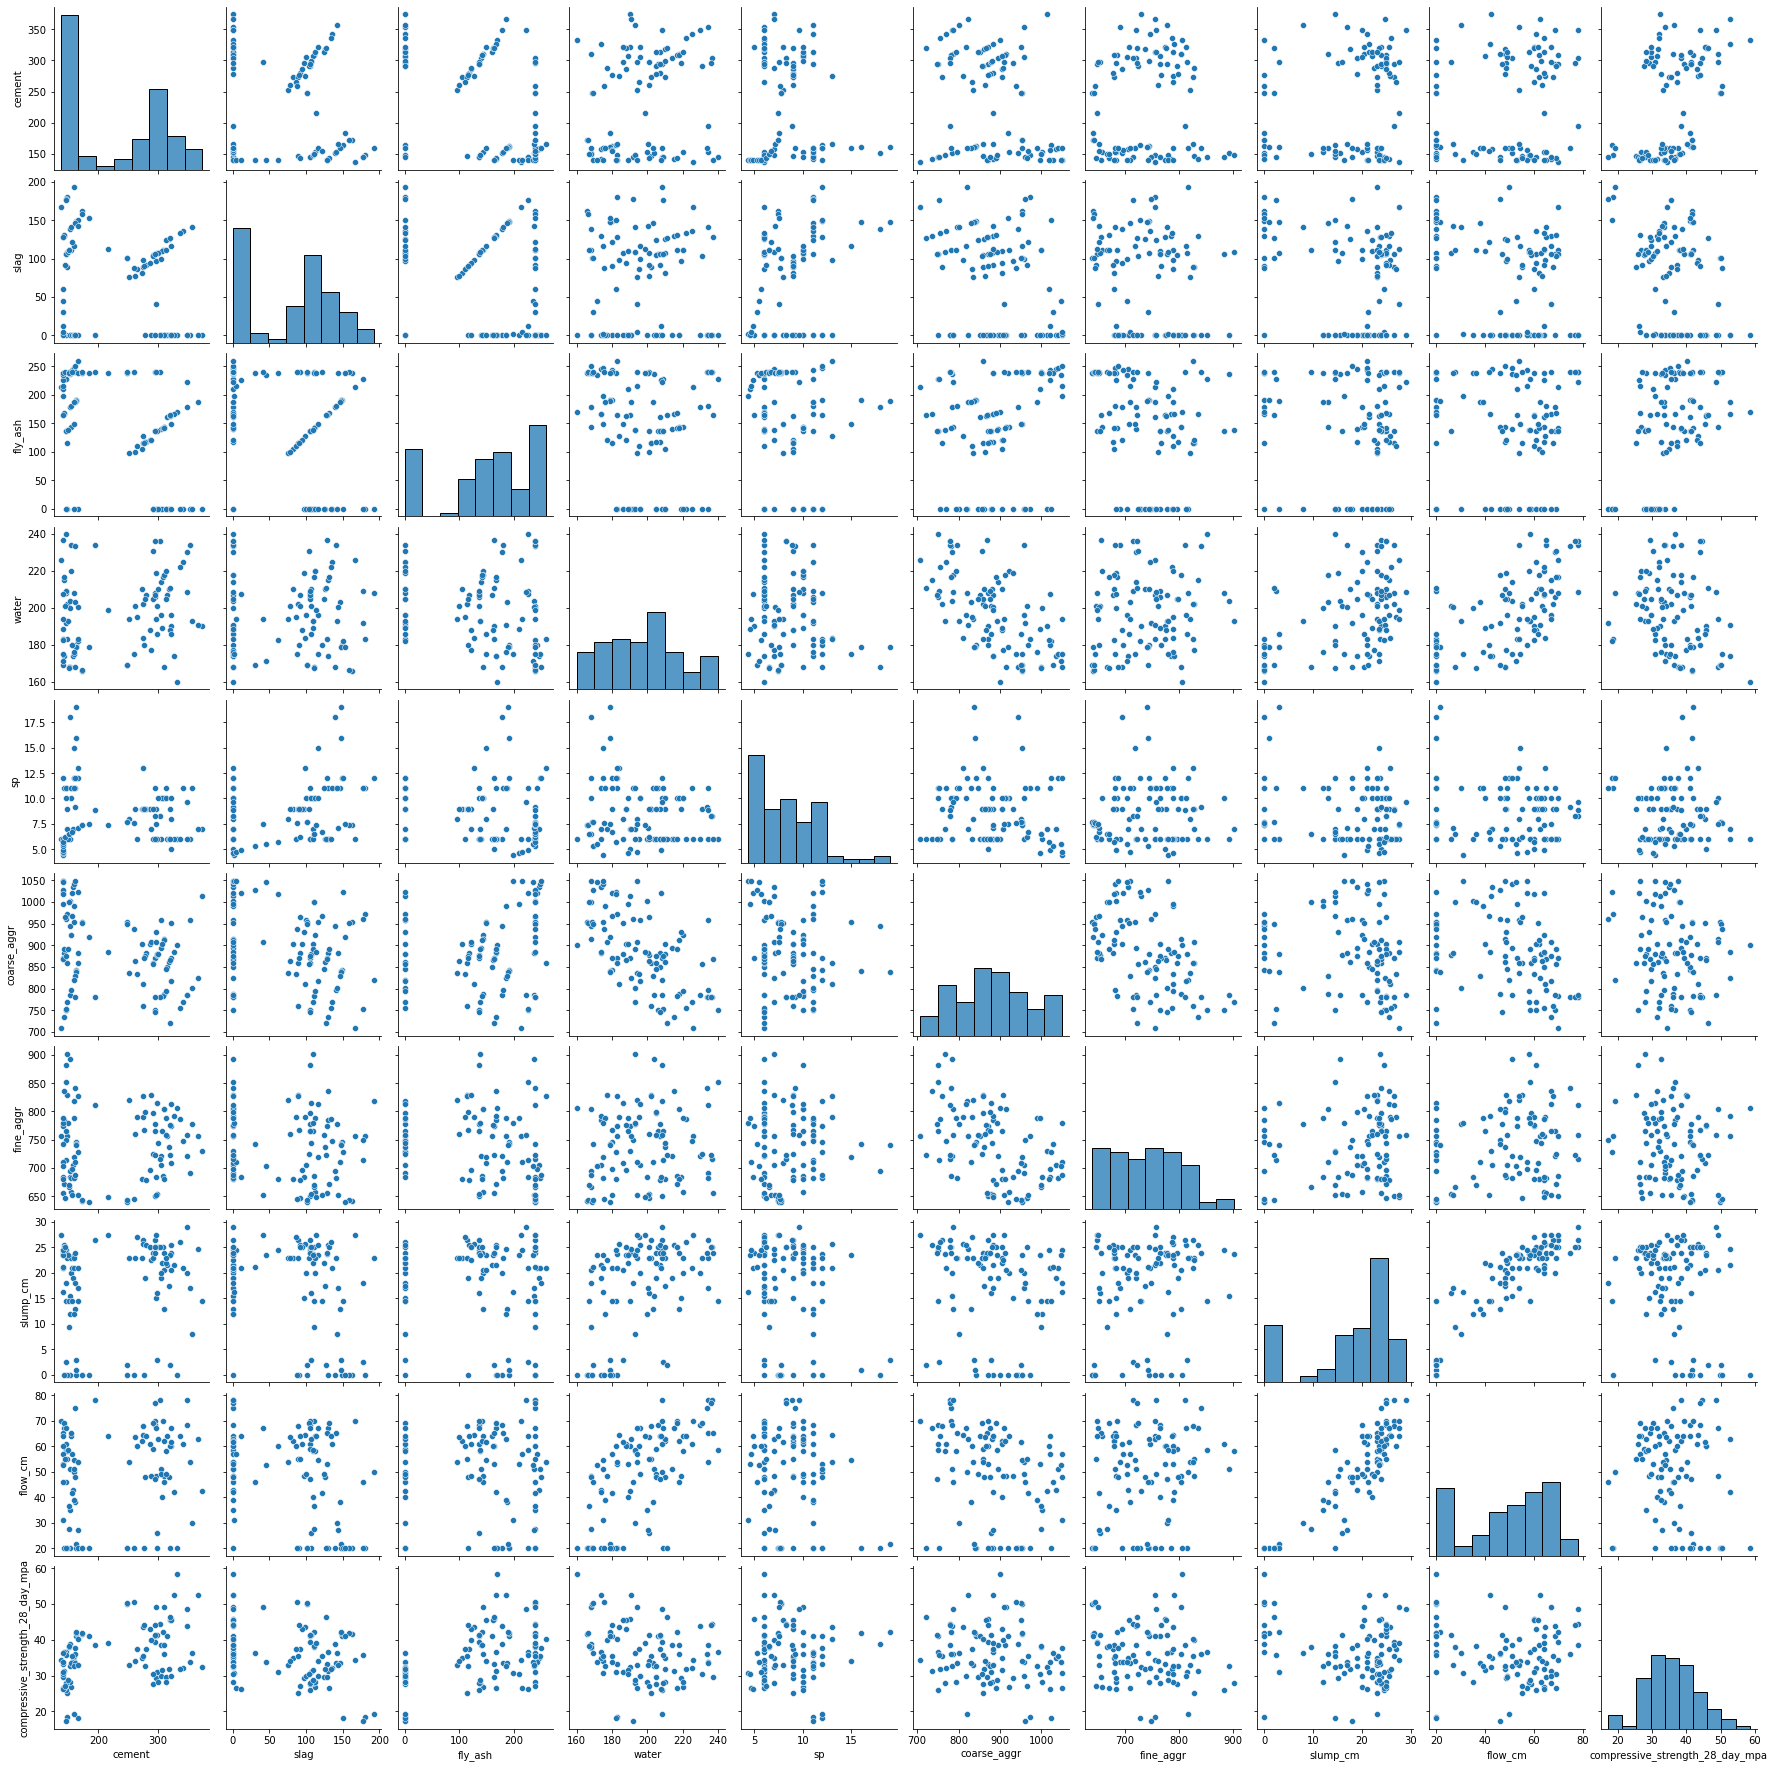

In [46]:
sns.pairplot(df);

# Data Preprocessing 

### Features and target variable

In [47]:
X=df.drop(['compressive_strength_28_day_mpa'],axis=1)
Y=df['compressive_strength_28_day_mpa']

### Splitting data into training and testing

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Scaling

In [49]:
scaler = StandardScaler()

In [50]:
scaler.fit(X_train)

StandardScaler()

In [51]:
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[ 0.99742015, -1.29720985, -0.03597016,  1.05552803,  0.49979299,
         0.26854971, -0.94918597,  0.70678525,  0.76407019],
       [-1.04096079,  1.65777393, -1.64936204, -0.65655824,  0.84332212,
         0.95172686,  0.28924939, -1.96043118, -1.59112335],
       [ 1.13668842,  0.78769537,  0.21399196,  0.71311078, -0.87432353,
        -1.90623086, -0.2575922 , -1.73816315, -1.59112335],
       [ 0.85815189,  0.45936384, -1.64936204, -0.50980799, -0.87432353,
        -0.10719771,  1.2220968 , -1.62702913, -1.59112335],
       [ 0.22891256,  0.36086438,  1.06727175, -1.34628443, -0.29032401,
         0.74905097, -1.58287887, -1.96043118, -1.59112335],
       [-0.90169252,  0.60711303,  0.04356324, -1.04789225,  2.21743863,
         0.73538743, -0.30584293,  0.65121824,  0.34349992],
       [ 0.80750889,  0.44294726, -0.10414165,  0.51744378, -0.87432353,
        -1.61018743,  0.62700448,  0.70678525, -0.07707036],
       [-0.93967478, -1.29720985,  1.11158322, -0.80330849,  0

In [52]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[ 1.14934917, -1.29720985,  0.21399196, -0.31414099, -1.21785265,
        -0.20967429,  0.56267018,  0.70678525,  0.65191812],
       [-0.81306726, -1.29720985,  1.30473577, -0.65655824,  1.53038037,
        -0.33492343,  1.41509971,  0.37338319,  0.3154619 ],
       [ 0.87081264,  0.45936384, -1.64936204,  0.66419403,  0.49979299,
        -0.08442514,  0.09624647,  0.81791927,  0.82014623],
       [ 0.71888363,  0.24594834, -0.27457037, -0.41197449,  0.15626386,
         0.17745943, -0.69184876,  0.81791927,  0.70799416],
       [-0.88903177,  1.09961032,  0.48667792,  0.32177677,  0.84332212,
        -0.676512  , -0.46667869, -0.51568895, -0.58175469],
       [-1.07894304,  1.6085242 ,  0.92979259,  0.61527728,  0.84332212,
        -1.553256  , -0.38626081, -1.68259614, -1.59112335],
       [-0.94727123,  0.70725415,  1.07749748, -0.80820017, -0.63385314,
         0.89251817, -1.39148432, -0.34898792, -0.38548856],
       [ 1.11136691,  0.77127879, -1.64936204,  0.66419403, -0

In [53]:
# checking std=1 and mean=0
pd.DataFrame(X_train_scaled).agg(["mean", "std"]).round(3)

,0,1,2,3,4,5,6,7,8
mean,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000
std,1.006,1.006,1.006,1.006,1.006,1.006,1.006,1.006,1.006


In [54]:
pd.DataFrame(X_test_scaled).agg(["mean", "std"]).round(3)

,0,1,2,3,4,5,6,7,8
mean,-0.020,-0.084,0.214,0.179,-0.009,-0.248,0.046,0.223,0.340
std,0.993,0.958,0.816,0.926,0.802,1.007,1.092,0.826,0.868


##  1. Model Building (Linear Regression)

In [56]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [57]:
lm.fit(X_train_scaled, y_train)

LinearRegression()

### 1.1 Interpret the model

In [58]:
y_pred = lm.predict(X_test_scaled)
y_train_pred = lm.predict(X_train_scaled)

In [59]:
lm_df = pd.DataFrame(lm.coef_, columns = ["lm_coef"])
lm_df

,lm_coef
0,4.280
1,-2.223
2,3.932
3,-4.771
4,0.121
5,-5.277
6,-2.611
7,-2.188
8,1.466


In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def train_val(y_train, y_train_pred, y_test, y_pred, model_name):
    
    scores = {model_name+"_train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    model_name+"_test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

In [61]:
ls =train_val(y_train, y_train_pred, y_test, y_pred, "linear")
ls

,linear_train,linear_test
R2,0.907,0.912
mae,1.936,1.740
mse,5.874,4.454
rmse,2.424,2.111


In [64]:
residuals = y_test-y_pred

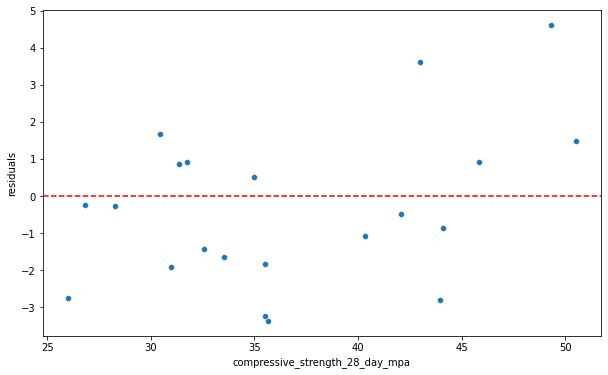

In [65]:
plt.figure(figsize = (10,6))
sns.scatterplot(x = y_test, y = residuals) #-residuals
plt.axhline(y = 0, color ="r", linestyle = "--")
plt.ylabel("residuals")
plt.show()

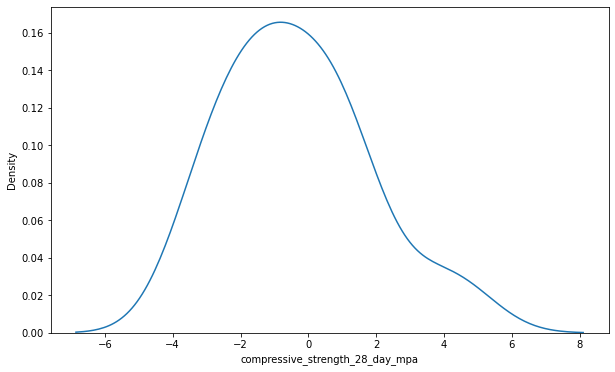

In [66]:
sns.kdeplot(residuals);

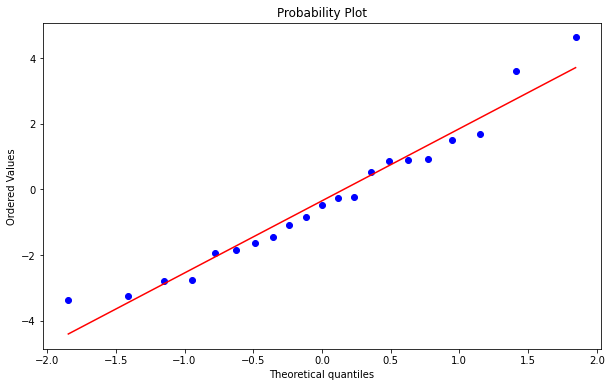

In [67]:
from scipy import stats

stats.probplot(residuals, dist ="norm", plot =plt);

In [68]:
from scipy.stats import skew
skew(residuals)

0.6026499074920302

### 1.2 Model Evaluation

In [69]:
from sklearn.model_selection import cross_validate, cross_val_score

In [70]:
model = LinearRegression()
scores = cross_validate(model, X_train_scaled, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

In [71]:
scores

{'fit_time': array([0.00199366, 0.00099993, 0.00099659, 0.00199509, 0.00199533,
        0.00199509, 0.02393961, 0.00099683, 0.00099587, 0.00099635]),
 'score_time': array([0.00199461, 0.00199294, 0.00199485, 0.00199437, 0.00199389,
        0.00199318, 0.00099802, 0.00099707, 0.00299239, 0.00199533]),
 'test_r2': array([0.94543648, 0.94337382, 0.59394067, 0.68802557, 0.65972087,
        0.93274303, 0.90766953, 0.91515243, 0.82617985, 0.85001894]),
 'test_neg_mean_absolute_error': array([-1.71210248, -1.81922645, -2.81143141, -2.97077054, -2.04148402,
        -1.19220736, -2.57914027, -2.23959694, -2.68533609, -2.46074018]),
 'test_neg_mean_squared_error': array([ -4.09558294,  -3.99581698, -11.14622448, -14.09675529,
         -6.36391248,  -1.87403305, -11.52752784,  -8.02877324,
        -11.13836649,  -6.95826423]),
 'test_neg_root_mean_squared_error': array([-2.02375466, -1.99895397, -3.33859618, -3.75456459, -2.52267962,
        -1.36895327, -3.39522132, -2.833509  , -3.33741914, -2.

In [72]:
pd.DataFrame(scores, index = range(1,11))

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,0.002,0.002,0.945,-1.712,-4.096,-2.024
2,0.001,0.002,0.943,-1.819,-3.996,-1.999
3,0.001,0.002,0.594,-2.811,-11.146,-3.339
4,0.002,0.002,0.688,-2.971,-14.097,-3.755
5,0.002,0.002,0.660,-2.041,-6.364,-2.523
6,0.002,0.002,0.933,-1.192,-1.874,-1.369
7,0.024,0.001,0.908,-2.579,-11.528,-3.395
8,0.001,0.001,0.915,-2.240,-8.029,-2.834
9,0.001,0.003,0.826,-2.685,-11.138,-3.337
10,0.001,0.002,0.850,-2.461,-6.958,-2.638


In [73]:
scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                             0.826
test_neg_mean_absolute_error       -2.251
test_neg_mean_squared_error        -7.923
test_neg_root_mean_squared_error   -2.721
dtype: float64

In [74]:
train_val(y_train, y_train_pred, y_test, y_pred, "linear")

,linear_train,linear_test
R2,0.907,0.912
mae,1.936,1.740
mse,5.874,4.454
rmse,2.424,2.111


In [76]:
lm.coef_

array([ 4.28015177, -2.22287954,  3.9320198 , -4.77083923,  0.12109966,
       -5.27729122, -2.61131342, -2.18837804,  1.46570621])

In [77]:
lm_df = pd.DataFrame(lm.coef_, columns = ["lm_coef"])
lm_df

,lm_coef
0,4.280
1,-2.223
2,3.932
3,-4.771
4,0.121
5,-5.277
6,-2.611
7,-2.188
8,1.466


# 2. Regularization

## 2.1 Ridge (Apply and evaluate)

In [78]:
from sklearn.linear_model import Ridge

In [79]:
ridge_model = Ridge(alpha=1)

In [80]:
ridge_model.fit(X_train_scaled, y_train)

Ridge(alpha=1)

In [81]:
y_pred = ridge_model.predict(X_test_scaled)
y_train_pred = ridge_model.predict(X_train_scaled)

In [82]:
rs = train_val(y_train, y_train_pred, y_test, y_pred, "ridge")
rs

,ridge_train,ridge_test
R2,0.906,0.911
mae,1.938,1.732
mse,5.922,4.493
rmse,2.434,2.120


In [83]:
pd.concat([ls, rs], axis=1)

,linear_train,linear_test,ridge_train,ridge_test
R2,0.907,0.912,0.906,0.911
mae,1.936,1.740,1.938,1.732
mse,5.874,4.454,5.922,4.493
rmse,2.424,2.111,2.434,2.120


In [84]:
# for ridge regression cross validation with alpha:1
model = Ridge(alpha=1)
scores = cross_validate(model, X_train_scaled, y_train,
                    scoring=['r2', 'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv=10)

In [85]:
pd.DataFrame(scores, index = range(1, 11))

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,0.002,0.003,0.946,-1.717,-4.067,-2.017
2,0.002,0.001,0.954,-1.625,-3.270,-1.808
3,0.002,0.002,0.576,-2.892,-11.632,-3.411
4,0.001,0.003,0.702,-2.894,-13.470,-3.670
5,0.001,0.002,0.693,-1.932,-5.745,-2.397
6,0.001,0.002,0.927,-1.271,-2.045,-1.430
7,0.001,0.002,0.898,-2.690,-12.720,-3.567
8,0.002,0.002,0.924,-2.073,-7.239,-2.691
9,0.001,0.003,0.826,-2.670,-11.176,-3.343
10,0.001,0.001,0.851,-2.454,-6.928,-2.632


In [86]:
scores = pd.DataFrame(scores, index = range(1, 11))
scores.iloc[:,2:].mean()

test_r2                             0.829
test_neg_mean_absolute_error       -2.222
test_neg_mean_squared_error        -7.829
test_neg_root_mean_squared_error   -2.696
dtype: float64

In [87]:
train_val(y_train, y_train_pred, y_test, y_pred, "ridge")

,ridge_train,ridge_test
R2,0.906,0.911
mae,1.938,1.732
mse,5.922,4.493
rmse,2.434,2.120


In [88]:
ridge_model.coef_

array([ 5.01092233, -1.37765187,  4.8062743 , -3.90644878,  0.26138511,
       -4.06644253, -1.74660531, -1.95498663,  1.13349998])

In [89]:
rm_df = pd.DataFrame(ridge_model.coef_, columns = ["ridge_coef_1"])
rm_df

,ridge_coef_1
0,5.011
1,-1.378
2,4.806
3,-3.906
4,0.261
5,-4.066
6,-1.747
7,-1.955
8,1.133


In [90]:
pd.concat([lm_df,rm_df], axis = 1)

,lm_coef,ridge_coef_1
0,4.280,5.011
1,-2.223,-1.378
2,3.932,4.806
3,-4.771,-3.906
4,0.121,0.261
5,-5.277,-4.066
6,-2.611,-1.747
7,-2.188,-1.955
8,1.466,1.133


In [ ]:
# choosing best alpha value with GridSearch CV for Ridge

In [91]:
from sklearn.model_selection import GridSearchCV

In [92]:
alpha_space = np.linspace(0.01, 1, 100)
alpha_space

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

In [93]:
ridge_model = Ridge()

In [94]:
param_grid = {"alpha":alpha_space}

In [95]:
grid_ridge = GridSearchCV(estimator = ridge_model, param_grid = param_grid, scoring = 'neg_root_mean_squared_error',
                         cv =10, verbose =2)

In [96]:
grid_ridge.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.02; total time=   0.0s
[CV] END ...................................

[CV] END .........................................alpha=0.17; total time=   0.0s
[CV] END ..........................alpha=0.18000000000000002; total time=   0.0s
[CV] END ..........................alpha=0.18000000000000002; total time=   0.0s
[CV] END ..........................alpha=0.18000000000000002; total time=   0.0s
[CV] END ..........................alpha=0.18000000000000002; total time=   0.0s
[CV] END ..........................alpha=0.18000000000000002; total time=   0.0s
[CV] END ..........................alpha=0.18000000000000002; total time=   0.0s
[CV] END ..........................alpha=0.18000000000000002; total time=   0.0s
[CV] END ..........................alpha=0.18000000000000002; total time=   0.0s
[CV] END ..........................alpha=0.18000000000000002; total time=   0.0s
[CV] END ..........................alpha=0.18000000000000002; total time=   0.0s
[CV] END .........................................alpha=0.19; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=0.33; total time=   0.0s
[CV] END .........................................alpha=0.33; total time=   0.0s
[CV] END .........................................alpha=0.33; total time=   0.0s
[CV] END .........................................alpha=0.33; total time=   0.0s
[CV] END .........................................alpha=0.33; total time=   0.0s
[CV] END .........................................alpha=0.34; total time=   0.0s
[CV] END .........................................alpha=0.34; total time=   0.0s
[CV] END .........................................alpha=0.34; total time=   0.0s
[CV] END .........................................alpha=0.34; total time=   0.0s
[CV] END .........................................alpha=0.34; total time=   0.0s
[CV] END .........................................alpha=0.34; total time=   0.0s
[CV] END .........................................alpha=0.34; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=0.52; total time=   0.0s
[CV] END .........................................alpha=0.52; total time=   0.0s
[CV] END .........................................alpha=0.52; total time=   0.0s
[CV] END .........................................alpha=0.52; total time=   0.0s
[CV] END .........................................alpha=0.52; total time=   0.0s
[CV] END .........................................alpha=0.52; total time=   0.0s
[CV] END .........................................alpha=0.52; total time=   0.0s
[CV] END .........................................alpha=0.52; total time=   0.0s
[CV] END .........................................alpha=0.52; total time=   0.0s
[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=0.66; total time=   0.0s
[CV] END .........................................alpha=0.66; total time=   0.0s
[CV] END .........................................alpha=0.66; total time=   0.0s
[CV] END .........................................alpha=0.67; total time=   0.0s
[CV] END .........................................alpha=0.67; total time=   0.0s
[CV] END .........................................alpha=0.67; total time=   0.0s
[CV] END .........................................alpha=0.67; total time=   0.0s
[CV] END .........................................alpha=0.67; total time=   0.0s
[CV] END .........................................alpha=0.67; total time=   0.0s
[CV] END .........................................alpha=0.67; total time=   0.0s
[CV] END .........................................alpha=0.67; total time=   0.0s
[CV] END .........................................alpha=0.67; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.8400000000000001; total time=   0.0s
[CV] END ...........................alpha=0.8400000000000001; total time=   0.0s
[CV] END ...........................alpha=0.8400000000000001; total time=   0.0s
[CV] END ...........................alpha=0.8400000000000001; total time=   0.0s
[CV] END ...........................alpha=0.8400000000000001; total time=   0.0s
[CV] END ...........................alpha=0.8400000000000001; total time=   0.0s
[CV] END ...........................alpha=0.8400000000000001; total time=   0.0s
[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=0.99; total time=   0.0s
[CV] END .........................................alpha=0.99; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='neg_root_mean_squared_error', verbose=2)

In [97]:
grid_ridge.best_params_

{'alpha': 0.92}

In [98]:
pd.DataFrame(grid_ridge.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002,0.001,0.000,0.000,0.010,{'alpha': 0.01},-2.022,-1.990,-3.340,-3.754,-2.514,-1.371,-3.397,-2.832,-3.338,-2.639,-2.720,0.721,100
1,0.002,0.001,0.001,0.000,0.020,{'alpha': 0.02},-2.020,-1.982,-3.341,-3.753,-2.507,-1.373,-3.399,-2.831,-3.339,-2.641,-2.719,0.722,99
2,0.002,0.000,0.001,0.001,0.030,{'alpha': 0.03},-2.019,-1.974,-3.343,-3.752,-2.500,-1.374,-3.401,-2.830,-3.339,-2.642,-2.717,0.723,98
3,0.001,0.000,0.000,0.000,0.040,{'alpha': 0.04},-2.017,-1.967,-3.344,-3.752,-2.494,-1.376,-3.403,-2.829,-3.340,-2.643,-2.716,0.724,97
4,0.001,0.000,0.000,0.000,0.050,{'alpha': 0.05},-2.016,-1.961,-3.345,-3.751,-2.488,-1.377,-3.405,-2.828,-3.340,-2.644,-2.715,0.725,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.001,0.000,0.000,0.000,0.960,{'alpha': 0.9600000000000001},-2.015,-1.810,-3.408,-3.673,-2.397,-1.428,-3.560,-2.696,-3.343,-2.633,-2.696,0.747,8
96,0.001,0.000,0.000,0.000,0.970,{'alpha': 0.97},-2.016,-1.810,-3.409,-3.672,-2.397,-1.429,-3.562,-2.694,-3.343,-2.633,-2.696,0.747,10
97,0.001,0.000,0.000,0.000,0.980,{'alpha': 0.98},-2.016,-1.809,-3.409,-3.672,-2.397,-1.429,-3.563,-2.693,-3.343,-2.633,-2.696,0.747,12
98,0.001,0.000,0.001,0.000,0.990,{'alpha': 0.99},-2.016,-1.809,-3.410,-3.671,-2.397,-1.430,-3.565,-2.692,-3.343,-2.632,-2.696,0.747,14


In [99]:
grid_ridge.best_index_

91

In [100]:
grid_ridge.best_score_

-2.696392988643864

In [101]:
y_pred = grid_ridge.predict(X_test_scaled)
y_train_pred = grid_ridge.predict(X_train_scaled)

In [102]:
rgs = train_val(y_train, y_train_pred, y_test, y_pred, "grid_ridge")
rgs

,grid_ridge_train,grid_ridge_test
R2,0.906,0.911
mae,1.938,1.732
mse,5.917,4.485
rmse,2.432,2.118


In [103]:
pd.concat([ls, rs, rgs], axis = 1)

,linear_train,linear_test,ridge_train,ridge_test,grid_ridge_train,grid_ridge_test
R2,0.907,0.912,0.906,0.911,0.906,0.911
mae,1.936,1.740,1.938,1.732,1.938,1.732
mse,5.874,4.454,5.922,4.493,5.917,4.485
rmse,2.424,2.111,2.434,2.120,2.432,2.118


In [105]:
rm = Ridge(alpha=0.92).fit(X_train_scaled, y_train) 
rm.coef_

array([ 5.00536166, -1.38916853,  4.79676356, -3.93112534,  0.25813578,
       -4.0917173 , -1.7629051 , -1.96963056,  1.1545175 ])

In [106]:
rgm_df = pd.DataFrame(rm.coef_, columns=["ridge_coef_0.92"])

In [107]:
pd.concat([lm_df,rm_df, rgm_df], axis = 1)


,lm_coef,ridge_coef_1,ridge_coef_0.92
0,4.280,5.011,5.005
1,-2.223,-1.378,-1.389
2,3.932,4.806,4.797
3,-4.771,-3.906,-3.931
4,0.121,0.261,0.258
5,-5.277,-4.066,-4.092
6,-2.611,-1.747,-1.763
7,-2.188,-1.955,-1.970
8,1.466,1.133,1.155


## 2.2 Lasso (Apply and evalute)

In [108]:
from sklearn.linear_model import Lasso

In [109]:
lasso_model = Lasso(alpha=1)
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=1)

In [110]:
y_pred = lasso_model.predict(X_test_scaled)
y_train_pred = lasso_model.predict(X_train_scaled)

In [111]:
lss = train_val(y_train, y_train_pred, y_test, y_pred, "lasso")
lss

,lasso_train,lasso_test
R2,0.776,0.802
mae,2.960,2.466
mse,14.144,10.036
rmse,3.761,3.168


In [112]:
pd.concat([ls, rs, rgs, lss], axis = 1)

,linear_train,linear_test,ridge_train,ridge_test,grid_ridge_train,grid_ridge_test,lasso_train,lasso_test
R2,0.907,0.912,0.906,0.911,0.906,0.911,0.776,0.802
mae,1.936,1.740,1.938,1.732,1.938,1.732,2.960,2.466
mse,5.874,4.454,5.922,4.493,5.917,4.485,14.144,10.036
rmse,2.424,2.111,2.434,2.120,2.432,2.118,3.761,3.168


In [ ]:
#for LASSO CV with default aplha :1

In [113]:
model = Lasso(alpha=1)
scores = cross_validate(model, X_train_scaled, y_train,
                        scoring=['r2', 'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv=10)

In [114]:
pd.DataFrame(scores, index = range(1, 11))

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,0.002,0.002,0.841,-2.871,-11.961,-3.458
2,0.001,0.003,0.851,-2.974,-10.515,-3.243
3,0.001,0.003,0.288,-3.807,-19.544,-4.421
4,0.002,0.002,0.559,-3.283,-19.926,-4.464
5,0.001,0.002,0.378,-2.750,-11.636,-3.411
6,0.001,0.002,0.715,-2.303,-7.945,-2.819
7,0.002,0.002,0.627,-5.206,-46.574,-6.825
8,0.002,0.001,0.854,-2.611,-13.855,-3.722
9,0.001,0.002,0.711,-3.485,-18.501,-4.301
10,0.001,0.001,0.768,-2.910,-10.778,-3.283


In [115]:
scores = pd.DataFrame(scores, index = range(1, 11))
scores.iloc[:,2:].mean()

test_r2                              0.659
test_neg_mean_absolute_error        -3.220
test_neg_mean_squared_error        -17.123
test_neg_root_mean_squared_error    -3.995
dtype: float64

In [116]:
train_val(y_train, y_train_pred, y_test, y_pred, "lasso")

,lasso_train,lasso_test
R2,0.776,0.802
mae,2.960,2.466
mse,14.144,10.036
rmse,3.761,3.168


In [117]:
lasso_model.coef_

array([ 4.82131411, -0.        ,  4.88005283, -0.81976891,  0.        ,
       -0.35149513, -0.        , -0.71063068, -0.        ])

In [118]:
lsm_df = pd.DataFrame(lasso_model.coef_, columns = ["lasso_coef_1"])

In [120]:
pd.concat([lm_df, rm_df, rgm_df, lsm_df], axis = 1)

,lm_coef,ridge_coef_1,ridge_coef_0.92,lasso_coef_1
0,4.280,5.011,5.005,4.821
1,-2.223,-1.378,-1.389,-0.000
2,3.932,4.806,4.797,4.880
3,-4.771,-3.906,-3.931,-0.820
4,0.121,0.261,0.258,0.000
5,-5.277,-4.066,-4.092,-0.351
6,-2.611,-1.747,-1.763,-0.000
7,-2.188,-1.955,-1.970,-0.711
8,1.466,1.133,1.155,-0.000


In [ ]:
# choosing best alpha value with GridSearchCV for LASSO

In [121]:
lasso_model = Lasso(max_iter=100000)

In [122]:
param_grid = {"alpha":alpha_space}

In [123]:
grid_lasso = GridSearchCV(estimator = lasso_model, param_grid = param_grid, scoring = 'neg_root_mean_squared_error',
                         cv =10, verbose =2)

In [124]:
grid_lasso.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.02; total time=   0.0s
[CV] END ...................................

[CV] END ..........................alpha=0.18000000000000002; total time=   0.0s
[CV] END .........................................alpha=0.19; total time=   0.0s
[CV] END .........................................alpha=0.19; total time=   0.0s
[CV] END .........................................alpha=0.19; total time=   0.0s
[CV] END .........................................alpha=0.19; total time=   0.0s
[CV] END .........................................alpha=0.19; total time=   0.0s
[CV] END .........................................alpha=0.19; total time=   0.0s
[CV] END .........................................alpha=0.19; total time=   0.0s
[CV] END .........................................alpha=0.19; total time=   0.0s
[CV] END .........................................alpha=0.19; total time=   0.0s
[CV] END .........................................alpha=0.19; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=0.37; total time=   0.0s
[CV] END .........................................alpha=0.37; total time=   0.0s
[CV] END .........................................alpha=0.37; total time=   0.0s
[CV] END .........................................alpha=0.37; total time=   0.0s
[CV] END .........................................alpha=0.37; total time=   0.0s
[CV] END .........................................alpha=0.37; total time=   0.0s
[CV] END .........................................alpha=0.37; total time=   0.0s
[CV] END .........................................alpha=0.37; total time=   0.0s
[CV] END .........................................alpha=0.38; total time=   0.0s
[CV] END .........................................alpha=0.38; total time=   0.0s
[CV] END .........................................alpha=0.38; total time=   0.0s
[CV] END .........................................alpha=0.38; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END .........................................alpha=0.53; total time=   0.0s
[CV] END .........................................alpha=0.54; total time=   0.0s
[CV] END .........................................alpha=0.54; total time=   0.0s
[CV] END .........................................alpha=0.54; total time=   0.0s
[CV] END .........................................alpha=0.54; total time=   0.0s
[CV] END .........................................alpha=0.54; total time=   0.0s
[CV] END .........................................alpha=0.54; total time=   0.0s
[CV] END .........................................alpha=0.54; total time=   0.0s
[CV] END .........................................alpha=0.54; total time=   0.0s
[CV] END .........................................alpha=0.54; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.6900000000000001; total time=   0.0s
[CV] END ...........................alpha=0.6900000000000001; total time=   0.0s
[CV] END ...........................alpha=0.7000000000000001; total time=   0.0s
[CV] END ...........................alpha=0.7000000000000001; total time=   0.0s
[CV] END ...........................alpha=0.7000000000000001; total time=   0.0s
[CV] END ...........................alpha=0.7000000000000001; total time=   0.0s
[CV] END ...........................alpha=0.7000000000000001; total time=   0.0s
[CV] END ...........................alpha=0.7000000000000001; total time=   0.0s
[CV] END ...........................alpha=0.7000000000000001; total time=   0.0s
[CV] END ...........................alpha=0.7000000000000001; total time=   0.0s
[CV] END ...........................alpha=0.7000000000000001; total time=   0.0s
[CV] END ...........................alpha=0.7000000000000001; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.8400000000000001; total time=   0.0s
[CV] END ...........................alpha=0.8400000000000001; total time=   0.0s
[CV] END ...........................alpha=0.8400000000000001; total time=   0.0s
[CV] END ...........................alpha=0.8400000000000001; total time=   0.0s
[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END .........................................alpha=0.85; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=0.97; total time=   0.0s
[CV] END .........................................alpha=0.97; total time=   0.0s
[CV] END .........................................alpha=0.97; total time=   0.0s
[CV] END .........................................alpha=0.97; total time=   0.0s
[CV] END .........................................alpha=0.97; total time=   0.0s
[CV] END .........................................alpha=0.98; total time=   0.0s
[CV] END .........................................alpha=0.98; total time=   0.0s
[CV] END .........................................alpha=0.98; total time=   0.0s
[CV] END .........................................alpha=0.98; total time=   0.0s
[CV] END .........................................alpha=0.98; total time=   0.0s
[CV] END .........................................alpha=0.98; total time=   0.0s
[CV] END .........................................alpha=0.98; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=10, estimator=Lasso(max_iter=100000),
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='neg_root_mean_squared_error', verbose=2)

In [125]:
grid_lasso.best_params_

{'alpha': 0.03}

In [126]:
pd.DataFrame(grid_lasso.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002,0.000,0.001,0.000,0.010,{'alpha': 0.01},-1.997,-1.873,-3.400,-3.743,-2.435,-1.438,-3.444,-2.859,-3.368,-2.732,-2.729,0.737,3
1,0.002,0.001,0.001,0.000,0.020,{'alpha': 0.02},-1.978,-1.766,-3.466,-3.732,-2.363,-1.500,-3.490,-2.873,-3.401,-2.783,-2.735,0.758,6
2,0.001,0.000,0.000,0.000,0.030,{'alpha': 0.03},-1.967,-1.684,-3.509,-3.698,-2.311,-1.503,-3.520,-2.859,-3.418,-2.779,-2.725,0.776,1
3,0.001,0.000,0.000,0.000,0.040,{'alpha': 0.04},-1.971,-1.651,-3.557,-3.665,-2.309,-1.509,-3.551,-2.850,-3.434,-2.775,-2.727,0.784,2
4,0.001,0.000,0.000,0.000,0.050,{'alpha': 0.05},-1.976,-1.627,-3.567,-3.632,-2.333,-1.518,-3.582,-2.845,-3.451,-2.772,-2.730,0.786,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.001,0.000,0.000,0.000,0.960,{'alpha': 0.9600000000000001},-3.365,-3.164,-4.376,-4.363,-3.358,-2.747,-6.662,-3.595,-4.221,-3.225,-3.908,1.057,96
96,0.001,0.001,0.001,0.000,0.970,{'alpha': 0.97},-3.388,-3.183,-4.387,-4.388,-3.371,-2.765,-6.702,-3.627,-4.241,-3.239,-3.929,1.063,97
97,0.001,0.001,0.000,0.000,0.980,{'alpha': 0.98},-3.411,-3.203,-4.398,-4.413,-3.384,-2.783,-6.743,-3.658,-4.261,-3.254,-3.951,1.068,98
98,0.001,0.000,0.000,0.000,0.990,{'alpha': 0.99},-3.435,-3.223,-4.410,-4.438,-3.398,-2.801,-6.784,-3.690,-4.281,-3.268,-3.973,1.074,99


In [127]:
grid_lasso.best_index_

2

In [128]:
grid_lasso.best_score_

-2.7250101186493776

In [129]:
y_pred = grid_lasso.predict(X_test_scaled)
y_train_pred = grid_lasso.predict(X_train_scaled)

In [130]:
lgs = train_val(y_train, y_train_pred, y_test, y_pred, "grid_lasso")
lgs

,grid_lasso_train,grid_lasso_test
R2,0.905,0.912
mae,1.941,1.722
mse,6.003,4.439
rmse,2.450,2.107


In [131]:
pd.concat([ls, rs, rgs, lss, lgs], axis = 1)

,linear_train,linear_test,ridge_train,ridge_test,grid_ridge_train,grid_ridge_test,lasso_train,lasso_test,grid_lasso_train,grid_lasso_test
R2,0.907,0.912,0.906,0.911,0.906,0.911,0.776,0.802,0.905,0.912
mae,1.936,1.740,1.938,1.732,1.938,1.732,2.960,2.466,1.941,1.722
mse,5.874,4.454,5.922,4.493,5.917,4.485,14.144,10.036,6.003,4.439
rmse,2.424,2.111,2.434,2.120,2.432,2.118,3.761,3.168,2.450,2.107


In [134]:
lsm = Lasso(alpha=0.03).fit(X_train_scaled, y_train)
lsm.coef_

array([ 6.34371841, -0.        ,  6.32536397, -2.88078898,  0.42506412,
       -2.38925993, -0.46619636, -1.77863685,  0.92681106])

In [135]:
lgm_df = pd.DataFrame(lsm.coef_, columns=["lasso_coef_0.03"])

In [136]:
pd.concat([lm_df, rm_df, rgm_df, lsm_df, lgm_df], axis = 1)

,lm_coef,ridge_coef_1,ridge_coef_0.92,lasso_coef_1,lasso_coef_0.03
0,4.280,5.011,5.005,4.821,6.344
1,-2.223,-1.378,-1.389,-0.000,-0.000
2,3.932,4.806,4.797,4.880,6.325
3,-4.771,-3.906,-3.931,-0.820,-2.881
4,0.121,0.261,0.258,0.000,0.425
5,-5.277,-4.066,-4.092,-0.351,-2.389
6,-2.611,-1.747,-1.763,-0.000,-0.466
7,-2.188,-1.955,-1.970,-0.711,-1.779
8,1.466,1.133,1.155,-0.000,0.927


## 2.3 Elastic-Net (Apply and evaluate )
* Use Gridsearch for hyperparameter tuning instead of ElacticnetCV

In [137]:
from sklearn.linear_model import ElasticNet

In [139]:
elastic_model = ElasticNet(alpha=1, l1_ratio=0.03)
elastic_model.fit(X_train_scaled, y_train)

ElasticNet(alpha=1, l1_ratio=0.03)

In [140]:
y_pred = elastic_model.predict(X_test_scaled)
y_train_pred = elastic_model.predict(X_train_scaled)

In [141]:
es = train_val(y_train, y_train_pred, y_test, y_pred, "elastic")
es

,elastic_train,elastic_test
R2,0.583,0.582
mae,4.051,3.805
mse,26.376,21.174
rmse,5.136,4.602


In [142]:
pd.concat([ls,rs, rgs, lss, lgs, es], axis = 1)

,linear_train,linear_test,ridge_train,ridge_test,grid_ridge_train,grid_ridge_test,lasso_train,lasso_test,grid_lasso_train,grid_lasso_test,elastic_train,elastic_test
R2,0.907,0.912,0.906,0.911,0.906,0.911,0.776,0.802,0.905,0.912,0.583,0.582
mae,1.936,1.740,1.938,1.732,1.938,1.732,2.960,2.466,1.941,1.722,4.051,3.805
mse,5.874,4.454,5.922,4.493,5.917,4.485,14.144,10.036,6.003,4.439,26.376,21.174
rmse,2.424,2.111,2.434,2.120,2.432,2.118,3.761,3.168,2.450,2.107,5.136,4.602


In [143]:
# for ELastic_net CV with default alpha =1 and l1_ratio = 0.03

In [144]:
model = ElasticNet(alpha=1, l1_ratio=0.5)
scores = cross_validate(model, X_train_scaled, y_train,
                        scoring=['r2', 'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv=10)

In [145]:
scores = pd.DataFrame(scores, index = range(1, 11))
scores.iloc[:,2:]

,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,0.623,-4.218,-28.265,-5.316
2,0.555,-4.782,-31.396,-5.603
3,0.238,-3.950,-20.920,-4.574
4,0.510,-2.980,-22.153,-4.707
5,0.237,-3.124,-14.274,-3.778
6,0.473,-3.323,-14.698,-3.834
7,0.507,-6.127,-61.599,-7.848
8,0.679,-4.149,-30.359,-5.510
9,0.599,-4.202,-25.691,-5.069
10,0.622,-3.941,-17.553,-4.190


In [146]:
scores = pd.DataFrame(scores, index = range(1, 11))
scores.iloc[:,2:].mean()

test_r2                              0.504
test_neg_mean_absolute_error        -4.080
test_neg_mean_squared_error        -26.691
test_neg_root_mean_squared_error    -5.043
dtype: float64

In [147]:
train_val(y_train, y_train_pred, y_test, y_pred, "elastic")

,elastic_train,elastic_test
R2,0.583,0.582
mae,4.051,3.805
mse,26.376,21.174
rmse,5.136,4.602


In [148]:
elastic_model.coef_

array([ 2.04622704, -1.04261018,  2.05739682, -1.11033872,  0.03441364,
       -1.28104129, -0.59539376, -0.78656911, -0.26966268])

In [149]:
em_df = pd.DataFrame(elastic_model.coef_, columns=["elastic_coef_(alp:1, l1:0.03)"])

In [150]:
pd.concat([lm_df, rm_df, rgm_df, lsm_df, lgm_df, em_df], axis = 1)

,lm_coef,ridge_coef_1,ridge_coef_0.92,lasso_coef_1,lasso_coef_0.03,"elastic_coef_(alp:1, l1:0.03)"
0,4.280,5.011,5.005,4.821,6.344,2.046
1,-2.223,-1.378,-1.389,-0.000,-0.000,-1.043
2,3.932,4.806,4.797,4.880,6.325,2.057
3,-4.771,-3.906,-3.931,-0.820,-2.881,-1.110
4,0.121,0.261,0.258,0.000,0.425,0.034
5,-5.277,-4.066,-4.092,-0.351,-2.389,-1.281
6,-2.611,-1.747,-1.763,-0.000,-0.466,-0.595
7,-2.188,-1.955,-1.970,-0.711,-1.779,-0.787
8,1.466,1.133,1.155,-0.000,0.927,-0.270


In [ ]:
#choosing best alpha value with GrisSEarchCV for Elastic_net

In [151]:
from sklearn.model_selection import GridSearchCV

In [152]:
elastic_model = ElasticNet(max_iter=10000)

In [153]:
param_grid = {"alpha":[0.01, 0.012, 0.2, 0.5, 0.6, 0.7, 1],
            "l1_ratio":[0.01, 0.5, 0.7, 0.9, 0.95, 0.99, 1]}

In [154]:
grid_model = GridSearchCV(estimator = elastic_model, param_grid = param_grid, scoring = 'neg_root_mean_squared_error',
                         cv =10, verbose =2)

In [155]:
grid_model.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 49 candidates, totalling 490 fits
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=0.01, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.01

[CV] END ............................alpha=0.2, l1_ratio=0.7; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.7; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.7; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.7; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.7; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.7; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.7; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.7; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.9; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.9; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.9; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.9; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.7, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=0.7, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=0.7, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=0.7, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=0.7, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=0.7, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=0.7, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=0.7, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=0.7, l1_ratio=0.01; total time=   0.0s
[CV] END ............................alpha=0.7, l1_ratio=0.5; total time=   0.0s
[CV] END ............................alpha=0.7, l1_ratio=0.5; total time=   0.0s
[CV] END ............................alpha=0.7, l1_ratio=0.5; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=10, estimator=ElasticNet(max_iter=10000),
             param_grid={'alpha': [0.01, 0.012, 0.2, 0.5, 0.6, 0.7, 1],
                         'l1_ratio': [0.01, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [156]:
grid_model.best_params_

{'alpha': 0.012, 'l1_ratio': 0.01}

In [157]:
pd.DataFrame(grid_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003,0.001,0.000,0.000,0.010,0.010,"{'alpha': 0.01, 'l1_ratio': 0.01}",-2.009,-1.822,-3.396,-3.691,-2.398,-1.419,-3.524,-2.727,-3.345,-2.640,-2.697,0.745,2
1,0.002,0.001,0.000,0.000,0.010,0.500,"{'alpha': 0.01, 'l1_ratio': 0.5}",-2.000,-1.832,-3.394,-3.715,-2.401,-1.419,-3.482,-2.780,-3.353,-2.659,-2.703,0.744,4
2,0.001,0.000,0.000,0.000,0.010,0.700,"{'alpha': 0.01, 'l1_ratio': 0.7}",-1.998,-1.841,-3.394,-3.725,-2.407,-1.422,-3.465,-2.806,-3.357,-2.674,-2.709,0.742,6
3,0.001,0.000,0.000,0.000,0.010,0.900,"{'alpha': 0.01, 'l1_ratio': 0.9}",-1.997,-1.857,-3.396,-3.737,-2.420,-1.430,-3.450,-2.837,-3.363,-2.706,-2.719,0.740,8
4,0.001,0.000,0.000,0.000,0.010,0.950,"{'alpha': 0.01, 'l1_ratio': 0.95}",-1.997,-1.864,-3.398,-3.740,-2.426,-1.433,-3.446,-2.847,-3.365,-2.715,-2.723,0.739,9
5,0.001,0.001,0.000,0.000,0.010,0.990,"{'alpha': 0.01, 'l1_ratio': 0.99}",-1.997,-1.871,-3.399,-3.742,-2.433,-1.437,-3.444,-2.856,-3.367,-2.727,-2.727,0.737,11
6,0.001,0.000,0.000,0.000,0.010,1,"{'alpha': 0.01, 'l1_ratio': 1}",-1.997,-1.873,-3.400,-3.743,-2.435,-1.438,-3.444,-2.859,-3.368,-2.732,-2.729,0.737,12
7,0.001,0.001,0.000,0.000,0.012,0.010,"{'alpha': 0.012, 'l1_ratio': 0.01}",-2.013,-1.814,-3.404,-3.679,-2.397,-1.425,-3.548,-2.706,-3.344,-2.636,-2.696,0.746,1
8,0.001,0.001,0.000,0.000,0.012,0.500,"{'alpha': 0.012, 'l1_ratio': 0.5}",-2.001,-1.818,-3.402,-3.707,-2.396,-1.424,-3.498,-2.768,-3.354,-2.657,-2.703,0.746,3
9,0.001,0.000,0.000,0.000,0.012,0.700,"{'alpha': 0.012, 'l1_ratio': 0.7}",-1.997,-1.825,-3.403,-3.719,-2.399,-1.428,-3.478,-2.799,-3.359,-2.675,-2.708,0.745,5


In [158]:
grid_model.best_index_

7

In [159]:
grid_model.best_score_

-2.6964921490284746

In [160]:
y_pred = grid_model.predict(X_test_scaled) # ElasticNet(alpha=0.012, l1_ratio=0.01)
y_train_pred = grid_model.predict(X_train_scaled)

In [161]:
train_val(y_train, y_train_pred, y_test, y_pred, "GridSearch")

,GridSearch_train,GridSearch_test
R2,0.906,0.911
mae,1.938,1.732
mse,5.921,4.491
rmse,2.433,2.119
